In [5]:
#!/usr/bin/env python3
# ---------------------------------------  KernelSHAP convergence dashboard
import numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, Subset
from my_load import CPU_Unpickler
from numpy.random import default_rng
import matplotlib.gridspec as gridspec

# ------------------------------ 1. CONFIG ---------------------------------
#ROOT_DIR = Path("../output")
ROOT_DIR      = Path("../output/full-organs/true_positive_aggregation")                        # parent folder
PATIENT_IDS   = ["00004","00005","00024","00027",
                 "00029","00034","00039","00044"]
VAL_ROWS      = 40                                       # per patient
CHECKPOINTS   = np.arange(20, 1000+1, 20)                # samples used
RNG           = default_rng(0)                           # reproducible

FRAC_TARGET = 0.8                                  # target attribution fraction

# ------------------------------ 2. HELPERS --------------------------------
def active_count(abs_coefs: np.ndarray, frac: float = 0.95) -> int:
    """
    Return the minimal number of features whose |φ_i| sum to `frac`
    (e.g. 0.95) of the total attribution magnitude.

    If all |φ| sum to 0, returns 0.
    """
    total = abs_coefs.sum()
    if total == 0:  # all coefficients are zero 
        return 0
    sorted_abs = np.sort(abs_coefs)[::-1]
    cum = np.cumsum(sorted_abs)
    return int((cum < frac * total).sum() + 1)   # +1 for the first >=

def calculate_r2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate R² score with proper error handling.
    
    Returns 0.0 if total sum of squares is zero (constant target).
    """
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0

conv_L1, delta, val_mae, val_r2, nz_feat, cond_num = (
    [] for _ in range(6)
)

# ------------------------------ 3. MAIN LOOP ------------------------------
for pid in PATIENT_IDS:
    pkl_path   = ROOT_DIR / pid / "dataset.pkl"
    with open(pkl_path, "rb") as f:
        ds = CPU_Unpickler(f).load()
    if isinstance(ds, DataLoader):
        ds = ds.dataset
    X, y, w = (t.cpu() for t in ds.tensors)
    D = X.shape[1]
    f_x = y[0].item()                       # output for all-ones coalition

    # ---- 3.1 split fixed validation rows -------------------------------
    idx_all   = np.arange(X.shape[0])
    val_idx   = RNG.choice(idx_all, size=VAL_ROWS, replace=False)
    train_idx = np.setdiff1d(idx_all, val_idx, assume_unique=True)

    X_val, y_val = X[val_idx].numpy(), y[val_idx].numpy()

    # ---- 3.2 looping checkpoints --------------------------------------
    beta_prev = None
    cv, dl, mae, r2, cn = [], [], [], [], []

    coefs_list = []
    for n in CHECKPOINTS:
        n_train = min(n, len(train_idx))
        idx_sub = train_idx[:n_train]
        X_b, y_b, w_b = X[idx_sub].numpy(), y[idx_sub].numpy(), w[idx_sub].numpy()
        reg = LinearRegression()
        reg.fit(X_b, y_b, sample_weight=w_b)

        beta = torch.as_tensor(np.concatenate([[reg.intercept_], reg.coef_]),
                               dtype=torch.float32)

        # Save coefficients for sparsity calculation
        coefs_list.append(reg.coef_)

        # (1) coefficient jump
        if beta_prev is not None:
            cv.append(float(torch.norm(beta - beta_prev, p=1)))
        beta_prev = beta.clone()

        # (2) Δ_SHAP completeness residual
        dl.append(abs(f_x - beta.sum().item()))

        # (3) validation MAE
        y_pred_val = reg.intercept_ + X_val @ reg.coef_
        mae.append(float(np.abs(y_val - y_pred_val).mean()))

        # (4) validation R²
        r2_val = calculate_r2(y_val, y_pred_val)
        r2.append(r2_val)

        # (5) condition number
        Wsqrt = np.sqrt(w_b).reshape(-1,1)
        Xw    = np.column_stack([np.ones(n_train), X_b]) * Wsqrt
        try:
            U, svals, _ = np.linalg.svd(Xw, full_matrices=False)
            cn.append(svals[0] / svals[-1])
        except np.linalg.LinAlgError:
            cn.append(np.inf)

    # (6) sparsity: use active_count for all checkpoints
    nnz = [active_count(np.abs(c), FRAC_TARGET) for c in coefs_list]

    conv_L1.append(cv); delta.append(dl); val_mae.append(mae)
    val_r2.append(r2); nz_feat.append(nnz); cond_num.append(cn)



/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_32449/2962206602.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved → convergence_dashboard.png


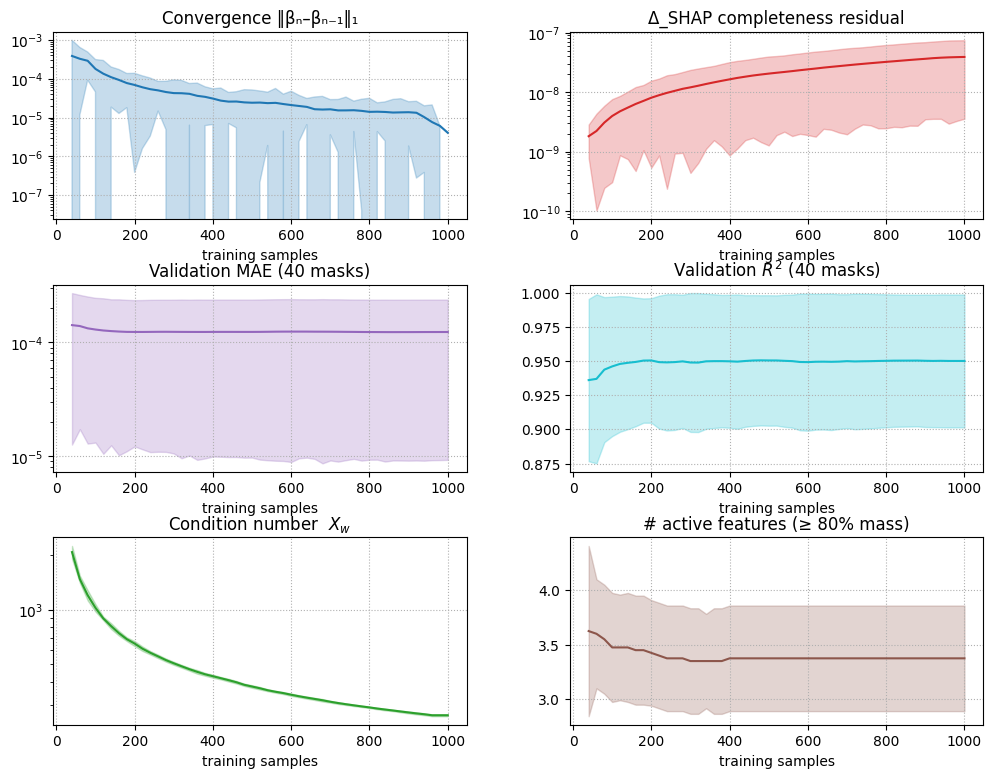

In [6]:
# ------------------------------ 4. AGGREGATE ------------------------------
to_stats = lambda lst: (np.mean(lst, axis=0), np.std(lst, axis=0))
conv_m, conv_s   = to_stats(conv_L1)
delta_m, delta_s = to_stats(delta)
mae_m,  mae_s    = to_stats(val_mae)
r2_m,   r2_s     = to_stats(val_r2)
nz_m,   nz_s     = to_stats(nz_feat)
cond_m, cond_s   = to_stats(cond_num)

# ------------------------- helper: one–sided moving average ----------------
def smooth(arr: np.ndarray, win: int = 5) -> np.ndarray:
    """Boundary-aware moving average (window ≤ 2·pad+1, centre-aligned)."""
    pad = win // 2
    sm  = np.empty_like(arr)
    for i in range(len(arr)):
        lo, hi = max(0, i - pad), min(len(arr), i + pad + 1)
        sm[i] = arr[lo:hi].mean()
    return sm

# --------- light smoothing (window = 5 checkpoints) -----------------------
for arr in (conv_m, delta_m, mae_m, nz_m):
    arr[:] = smooth(arr, win=5)  # inplace modification

# ------------------------------ 5. PLOTTING -------------------------------

x_conv = CHECKPOINTS[1:]      # 199 points, conv/delta start at 2nd cp


fig = plt.figure(figsize=(12,9))
gs  = gridspec.GridSpec(3,2, hspace=0.35, wspace=0.25)
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(2)]

def shaded(ax, x, y, s, **kw):
    ax.plot(x, y, **kw)
    ax.fill_between(x, y-s, y+s, alpha=.25, **kw)

# Row-1
shaded(axes[0], x_conv, conv_m,   conv_s,   color='tab:blue')
axes[0].set_yscale('log'); axes[0].set_title('Convergence ‖βₙ–βₙ₋₁‖₁'); axes[0].grid(ls=':')
shaded(axes[1], x_conv, delta_m[1:], delta_s[1:], color='tab:red')  # <-- slice
axes[1].set_yscale('log'); axes[1].set_title('Δ_SHAP completeness residual'); axes[1].grid(ls=':')

# Row 2 ....................................................................
shaded(axes[2], x_conv, mae_m[1:],  mae_s[1:],  color='tab:purple')
axes[2].set_yscale('log'); axes[2].set_title('Validation MAE (40 masks)')
axes[2].grid(ls=':')

shaded(axes[3], x_conv, r2_m[1:],   r2_s[1:],  color='tab:cyan')
axes[3].set_title(f'Validation $R^2$ ({VAL_ROWS} masks)')
axes[3].grid(ls=':')

# Row 3 ....................................................................
shaded(axes[4], x_conv, cond_m[1:], cond_s[1:], color='tab:green')
axes[4].set_yscale('log'); axes[4].set_title('Condition number  $X_w$')
axes[4].grid(ls=':')

shaded(axes[5], x_conv, nz_m[1:],   nz_s[1:],  color='tab:brown')
axes[5].set_title(f'# active features (≥ {FRAC_TARGET * 100:.0f}% mass)')
axes[5].grid(ls=':')

for ax in axes: ax.set_xlabel('training samples')

fig.tight_layout()
fig.savefig('convergence_dashboard.png', dpi=300)
print("Saved → convergence_dashboard.png")